In [1]:
import sys
sys.path.append('..')

# DenseNet121

In [2]:
import argparse
import json
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from data.images.images import PtbXlDataModule
from models.images.images import ImageClassifier
from train_poincare import set_seed

Global seed set to 42
Global seed set to 42


In [32]:
DEVICE = torch.device('cuda:0')
class args:
    data_path='/home/huypham/Projects/ecg/dataset/cinc2017'
    batch_size=64
    log_dir='/home/huypham/Projects/ecg/tmp/logs_cinc2017'
    ckpt_path='/home/huypham/Projects/ecg/logs_with_eco2ai/logs_cinc2017/poincare/densenet121/lightning_logs/version_0/ckpt/best-epoch=9-val_loss=0.30-val_f1=0.75.ckpt'
    seed=42

In [7]:
os.makedirs(args.log_dir, exist_ok=True)

In [8]:
train_dir = os.path.join(args.data_path, 'processed')
train_label = os.path.join(args.data_path, 'processed/y_train.csv')
val_dir = os.path.join(args.data_path, 'processed')
val_label = os.path.join(args.data_path, 'processed/y_val.csv')
test_dir = os.path.join(args.data_path, 'processed')
test_label = os.path.join(args.data_path, 'processed/y_test.csv')

datamodule = PtbXlDataModule(
    train_dir=train_dir,
    train_label=train_label,
    val_dir=val_dir,
    val_label=val_label,
    test_dir=test_dir,
    test_label=test_label,
    batch_size=args.batch_size
)

Global seed set to 42
Global seed set to 42


In [11]:
val_data = datamodule.test_dataloader()
val_len = len(val_data)

Global seed set to 42


In [9]:
classes = datamodule.train_dataset.labels.columns
saved_model = ImageClassifier.load_from_checkpoint(
    args.ckpt_path,
    classes=classes,
    barebone='densenet121', # 'vit_b_16'
    learning_rate=5e-4,
    loss_type='bce')

Global seed set to 42


In [10]:
model = saved_model.network.to('cuda:0')
if saved_model.barebone.startswith('resnet'):
    target_layers = [model.layer4[-1]]
elif saved_model.barebone.startswith('densenet'):
    target_layers = [model.features[-1]]

In [20]:
CAM = GradCAM
cam = CAM(model=model, target_layers=target_layers, use_cuda=True)

In [33]:
output_dir = os.path.join(args.log_dir, 'cam_output', CAM.__name__)
os.makedirs(output_dir, exist_ok=True)

Get Prediction:   0%|          | 0/27 [00:00<?, ?it/s]

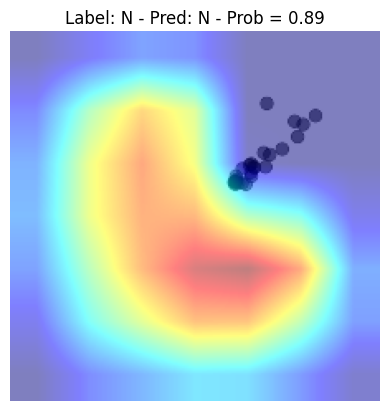

In [34]:
predictions = dict()
for idx, data in tqdm(enumerate(val_data), total=val_len, desc='Get Prediction'):
    input_tensor = data['image'].to(DEVICE)
    label = data['label'].cpu().numpy()
    label_id = label.argmax()

    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)

    for b in range(probs.shape[0]):
        filename = f"batch-{idx:03d}-{b:03d}.png"
        prob = probs[b]
        pred_id = prob.argmax().item()
        prob = prob.max().item()

        predictions[filename] = dict(
            label=classes[label_id],
            pred=classes[pred_id],
            prob=prob
        )

        if (label_id == pred_id) and (prob > 0.8):
            grayscale_cam = cam(input_tensor=input_tensor[[b], :, :, :], targets=None)[0]
            rgb_img = input_tensor[b].permute(1, 2, 0).detach().cpu().numpy()
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

            plt.imshow(visualization)
            plt.axis('off')
            plt.title(f"Label: {classes[label_id]} - Pred: {classes[pred_id]} - Prob = {prob:.2f}")
            fp = os.path.join(output_dir, filename)
            plt.savefig(fp, bbox_inches='tight')

In [35]:
with open( os.path.join(args.log_dir, 'cam_output', 'predictions.json'), 'w') as f:
    json.dump(predictions, f)

# 1D ResNet

In [21]:
import sys
sys.path.append('..')

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


import argparse
import json

import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from data.images.images import PtbXlDataModule
from models.images.images import ImageClassifier
from train_poincare import set_seed

In [22]:
import scipy.io as sio
import biosppy as bp

# import matplotlib
# matplotlib.use('Agg')

In [23]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from data.timeseries.timeseries import TimeSeriesDataModule
from models.timeseries.cnn import Net1DLightningModule
from models.timeseries.resnet1d import *

import warnings
warnings.filterwarnings(action='ignore')

In [24]:
class args:
    data_path='/home/huypham/Projects/ecg/dataset/cinc2017/raw/training'
    csv_path='/home/huypham/Projects/ecg/dataset/cinc2017/processed'
    batch_size=32
    learning_rate=1e-4
    max_epochs=500
    log_dir='./logs/resnet1d'
    resume_from_checkpoint=None
    seed=42

In [27]:
train_dir = args.data_path
val_dir = train_dir
test_dir = train_dir

train_label = os.path.join(args.csv_path, 'y_train.csv') # '/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_train.csv'
val_label = os.path.join(args.csv_path, 'y_val.csv')
test_label = os.path.join(args.csv_path, 'y_test.csv')

data_module = TimeSeriesDataModule(
    train_dir=train_dir,
    train_label=train_label,
    val_dir=val_dir,
    val_label=val_label,
    test_dir=test_dir,
    test_label=test_label,
    batch_size=args.batch_size
)

# train_dataloader = data_module.train_dataloader()
classes = data_module.train_dataset.classes
class_weights = data_module.train_dataset.class_weights

# val_dataloader = data_module.val_dataloader()
test_dataloader = data_module.test_dataloader()

Global seed set to 42
Global seed set to 42


  0%|          | 0/5116 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/1706 [00:00<?, ?it/s]

Global seed set to 42


  0%|          | 0/1706 [00:00<?, ?it/s]

In [28]:
from models.timeseries.resnet1d import ResNet1DLightningModule

pl_model = ResNet1DLightningModule.load_from_checkpoint(
    '/home/huypham/Projects/ecg/logs_with_eco2ai/logs_cinc2017/resnet1d/lightning_logs/version_0/ckpt/best-epoch=97-val_loss=0.03-val_f1=0.83.ckpt',
    classes=classes,
    class_weights=class_weights,
    learning_rate=args.learning_rate
)

Global seed set to 42


In [29]:
model = pl_model.model
# model = ResNet1d(BasicBlock1d, [2, 2, 2, 2], input_channels=1, inplanes=64, num_classes=len(classes))

In [30]:
import numpy as np
import torch
import ttach as tta
from typing import Callable, List, Tuple
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
# from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2


def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            # import pdb;pdb.set_trace()
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result

class BaseCAM:
    def __init__(self,
                 model: torch.nn.Module,
                 target_layers: List[torch.nn.Module],
                 use_cuda: bool = False,
                 reshape_transform: Callable = None,
                 compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor: torch.Tensor,
                        target_layers: List[torch.nn.Module],
                        targets: List[torch.nn.Module],
                        activations: torch.Tensor,
                        grads: torch.Tensor) -> np.ndarray:
        # raise Exception("Not Implemented")
        return grads

    def get_cam_image(self,
                      input_tensor: torch.Tensor,
                      target_layer: torch.nn.Module,
                      targets: List[torch.nn.Module],
                      activations: torch.Tensor,
                      grads: torch.Tensor,
                      eigen_smooth: bool = False) -> np.ndarray:

        weights = self.get_cam_weights(input_tensor,
                                       target_layer,
                                       targets,
                                       activations,
                                       grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self,
                input_tensor: torch.Tensor,
                targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(
                category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output)
                       for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   targets,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    def get_target_width_height(self,
                                input_tensor: torch.Tensor) -> Tuple[int, int]:
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor: torch.Tensor,
            targets: List[torch.nn.Module],
            eigen_smooth: bool) -> np.ndarray:
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     targets,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam = np.maximum(cam, 0)
            # import pdb; pdb.set_trace()
            scaled = scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(
            self,
            cam_per_target_layer: np.ndarray) -> np.ndarray:
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return scale_cam_image(result)

    def forward_augmentation_smoothing(self,
                                       input_tensor: torch.Tensor,
                                       targets: List[torch.nn.Module],
                                       eigen_smooth: bool = False) -> np.ndarray:
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               targets,
                               eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor: torch.Tensor,
                 targets: List[torch.nn.Module] = None,
                 aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, targets, eigen_smooth)

        return self.forward(input_tensor,
                            targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True

In [31]:
class ResNet1dCam:
    def __init__(self, model, target_layers):
        self.cam = BaseCAM(model=model, target_layers=target_layers, use_cuda=True)
    def __call__(self, input_tensor, targets=None):
        cam_out = self.cam(input_tensor=input_tensor, targets=targets)
        return cam_out

In [32]:
!rm -rf /home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d/GradCAM/*

zsh:1: no matches found: /home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d/GradCAM/*


In [33]:
out_dir = os.path.join(
    '/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d',
    'GradCAM/' # adaptiveavgpool
)
os.makedirs(out_dir, exist_ok=True)
output = []

cam = ResNet1dCam(model, target_layers=[model.adaptiveavgpool, model.adaptivemaxpool])

for bid, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader.dataset)//args.batch_size):
    with torch.no_grad():
        logits = model(data['data'].to('cuda:0'))
        probs = torch.sigmoid(logits)
    
    
    bs = logits.shape[0]

    for idx in range(bs):
        fp = os.path.join(out_dir, filename)
        label_id = data['label'][idx].argmax().item()
        label_class = classes[label_id]
        filename = f"batch-{bid:03d}-{idx:03d}--{label_class}.png"

        prob = probs[idx]
        pred_id = prob.argmax().item()
        pred_class = classes[pred_id]

        if (label_id == pred_id) and (prob[pred_id].item() > 0.8):
            mat_fp = data['fp'][idx] + '.mat'
            hea_fp = data['fp'][idx] + '.hea'

            signal = sio.loadmat(mat_fp)['val'].flatten()
            with open(hea_fp) as f:
                headers = f.readlines()
            sampling_rate = int(headers[0].split(' ')[2])
            out = bp.signals.ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)[1]


            grayscale_cam = cam(input_tensor=data['data'][[idx]], targets=None).flatten()
            grad = grayscale_cam[:len(out)]

            max_grad_id = grad.argmax()

            a = max(0, max_grad_id - sampling_rate * 5)
            b = min(a + sampling_rate * 10, len(out))
            # b = min(len(out), sampling_rate*)

            grad = grad[a:b]
            out = out[a:b]

            fig, ax1 = plt.subplots(figsize=(10, 2))
            ax2 = ax1.twinx()

            ax1.pcolormesh([grad]*2)

            ax2.plot(out, color='red')

            ax1.axis('off')
            ax2.axis('off')
            plt.title(f"Label: {label_class} - Pred: {pred_class} - Prob = {prob[pred_id].item():.2f}")
            fp = os.path.join(out_dir, filename)
            plt.savefig(fp, bbox_inches='tight')
            plt.close()

            output.append(dict(filename=filename, label=label_class, pred=pred_class, prob=prob[pred_id].item()))
    # break

import json
with open(os.path.join('/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d', 'predictions.json'), 'w') as f:
    json.dump(output, f)


54it [02:56,  3.27s/it]                        


In [113]:
# out_dir = os.path.join(
#     '/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d',
#     'GradCAM/adaptivemaxpool'
# )
# os.makedirs(out_dir, exist_ok=True)
# output = []

# cam = ResNet1dCam(model, target_layers=[model.adaptivemaxpool])

# for bid, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader.dataset)//args.batch_size):
#     with torch.no_grad():
#         logits = model(data['data'].to('cuda:0'))
#         probs = torch.sigmoid(logits)
    
    
#     bs = logits.shape[0]

#     for idx in range(bs):
#         fp = os.path.join(out_dir, filename)
#         label_id = data['label'][idx].argmax().item()
#         label_class = classes[label_id]
#         filename = f"batch-{bid:03d}-{idx:03d}--{label_class}.png"

#         prob = probs[idx]
#         pred_id = prob.argmax().item()
#         pred_class = classes[pred_id]

#         if (label_id == pred_id) and (prob[pred_id].item() > 0.8):
#             mat_fp = data['fp'][idx] + '.mat'
#             hea_fp = data['fp'][idx] + '.hea'

#             signal = sio.loadmat(mat_fp)['val'].flatten()
#             with open(hea_fp) as f:
#                 headers = f.readlines()
#             sampling_rate = int(headers[0].split(' ')[2])
#             out = bp.signals.ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)[1]


#             grayscale_cam = cam(input_tensor=data['data'][[idx]], targets=None).flatten()
#             grad = grayscale_cam[:len(out)]

#             max_grad_id = grad.argmax()

#             a = max(0, max_grad_id - sampling_rate * 2)
#             b = min(a + sampling_rate * 4, len(grad))

#             grad = grad[a:b]
#             out = out[a:b]

#             fig, ax1 = plt.subplots(figsize=(10, 2))
#             ax2 = ax1.twinx()

#             ax1.pcolormesh([grad]*2)

#             ax2.plot(out, color='red')

#             ax1.axis('off')
#             ax2.axis('off')
#             plt.title(f"Label: {label_class} - Pred: {pred_class} - Prob = {prob[pred_id].item():.2f}")
#             fp = os.path.join(out_dir, filename)
#             plt.savefig(fp, bbox_inches='tight')
#             plt.close()

#             output.append(dict(filename=filename, label=label_class, pred=pred_class, prob=prob[pred_id].item()))
    
#     if bid > 1: break

# # import json
# # with open(os.path.join('/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d', 'predictions.json'), 'w') as f:
# #     json.dump(output, f)


  0%|          | 0/53 [00:00<?, ?it/s]

In [20]:
# out_dir = os.path.join(
#     '/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d',
#     'GradCAM/'
# )
# os.makedirs(out_dir, exist_ok=True)
# output = []

# cam = ResNet1dCam(model, target_layers=[model.adaptivemaxpool, model.adaptiveavgpool])

# for bid, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader.dataset)//args.batch_size):
#     with torch.no_grad():
#         logits = model(data['data'].to('cuda:0'))
#         probs = torch.sigmoid(logits)
    
    
#     bs = logits.shape[0]

#     for idx in range(bs):
#         label_id = data['label'][idx].argmax().item()
#         label_class = classes[label_id]
#         filename = f"batch-{bid:03d}-{idx:03d}--{label_class}.png"
#         fp = os.path.join(out_dir, filename)

#         prob = probs[idx]
#         pred_id = prob.argmax().item()
#         pred_class = classes[pred_id]

#         if (label_id == pred_id) and (prob[pred_id].item() > 0.8):
#             mat_fp = data['fp'][idx] + '.mat'
#             hea_fp = data['fp'][idx] + '.hea'

#             signal = sio.loadmat(mat_fp)['val'].flatten()
#             with open(hea_fp) as f:
#                 headers = f.readlines()
#             sampling_rate = int(headers[0].split(' ')[2])
#             out = bp.signals.ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)[1]


#             grayscale_cam = cam(input_tensor=data['data'][[idx]], targets=None).flatten()
#             grad = grayscale_cam[:len(out)]

#             max_grad_id = grad.argmax()

#             a = max(0, max_grad_id - sampling_rate * 2)
#             b = min(a + sampling_rate * 4, len(grad))

#             grad = grad[a:b]
#             out = out[a:b]

#             fig, ax1 = plt.subplots(figsize=(10, 2))
#             ax2 = ax1.twinx()

#             ax1.pcolormesh([grad]*2)

#             ax2.plot(out, color='red')

#             ax1.axis('off')
#             ax2.axis('off')
#             plt.title(f"Label: {label_class} - Pred: {pred_class} - Prob = {prob[pred_id].item():.2f}")
#             fp = os.path.join(out_dir, filename)
#             plt.savefig(fp, bbox_inches='tight')
#             plt.close()

#             output.append(dict(filename=filename, label=label_class, pred=pred_class, prob=prob[pred_id].item()))
    
#     if bid > 1: break

# # import json
# # with open(os.path.join('/home/huypham/Projects/ecg/tmp/logs_cinc2017/resnet1d', 'predictions.json'), 'w') as f:
# #     json.dump(output, f)


  4%|▍         | 2/53 [00:09<03:57,  4.65s/it]
